In [279]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START,END
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict
###--------------------tool importing-----------------###
from langchain_community.tools import WikipediaQueryRun, Tool
from langchain_community.utilities import WikipediaAPIWrapper,GoogleSerperAPIWrapper
import os
from dotenv import load_dotenv

In [280]:
class State(TypedDict):
  messages:Annotated[list, add_messages]
graph_builder=StateGraph(State)

In [281]:

load_dotenv()

True

In [282]:
api_key=os.getenv("GROQ_API_KEY")

In [283]:
llm = ChatGroq(api_key=api_key,model="meta-llama/llama-4-scout-17b-16e-instruct",temperature=0.2)

In [284]:
def router(state: State):
    query = state["messages"][-1].content

    router_prompt = f"""
You are a smart router. Classify this user query:

"{query}"

Options:
1. "memory" → If the question is static, historical, or definitional (encyclopedia-like).
2. "tools" → If the question needs current, real-time, or frequently changing data.
3. "both" → If both memory and external data are useful (e.g., context + current info).

Answer with one word only: memory, tools, or both.
    """

    decision = llm.invoke(router_prompt).content.strip().lower()
    if decision not in ["memory", "tools", "both"]:
        decision = "memory"  # fallback
    return decision


In [285]:
serpapi_api_key=os.getenv("SERP_API_KEY")
search = GoogleSerperAPIWrapper(serper_api_key=serpapi_api_key)
google_search = Tool(
  name="Google Search",
  func=search.run,
  description="Useful for answering questions about current events or real-time information from Google Search."
)

In [286]:

wiki_api_wrapper= WikipediaAPIWrapper()
wikipedia_tool=WikipediaQueryRun(api_wrapper=wiki_api_wrapper)

In [287]:
from langgraph.prebuilt import ToolNode, tools_condition
tool_node=ToolNode(tools=[google_search,wikipedia_tool])
graph_builder.add_node("tools",tool_node)

In [288]:
graph_builder.add_edge(START,"chatbot")


In [289]:
graph_builder.add_conditional_edges(
  "chatbot",
  tools_condition
)
graph_builder.add_edge("tools","chatbot")



In [290]:
def compare_answers(state: State):
    chatbot_ans = state.get("chatbot_answer", "")
    tool_ans = state.get("tool_answer", "")

    # Ask LLM to reconcile both
    prompt = f"""
You are an assistant. You have two possible answers to the user's question:

Answer from memory (may be outdated):
{chatbot_ans}

Answer from external search tools (likely more up-to-date):
{tool_ans}

Please give the most relevant, correct, and up-to-date answer to the user.
If the tool answer is empty or irrelevant, fallback to memory.
"""
    final = llm.invoke(prompt)
    return {"messages": [final]}

In [291]:
graph_builder.add_node("compare",compare_answers)
graph_builder.add_edge("compare",END)


In [292]:
graph = graph_builder.compile()

ValueError: Found edge starting at unknown node 'chatbot'

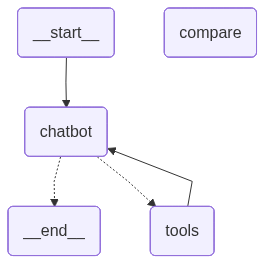

In [293]:
from IPython.display import Image, display
try:
  display(Image(graph.get_graph().draw_mermaid_png()))
except:
  pass

In [294]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: The richest man in the world is a title that changes frequently, as the net worth of billionaires fluctuates with market performance and other factors. However, according to the most recent data available from Forbes, which updates its billionaire rankings regularly, as of my last update:

**As of 2023, the richest man in the world is:**
- **Bernard Arnault**, with a net worth of approximately $231 billion. He is the chairman and CEO of LVMH (Moët Hennessy Louis Vuitton), the world's largest luxury goods company.

The rankings can change daily due to fluctuations in stock prices and other economic factors. Other notable mentions among the top 3 richest people in the world, according to recent updates, include:

1. **Elon Musk** - Founder of SpaceX and Tesla, Inc., with a net worth that frequently changes due to the volatile stock prices of Tesla.
2. **Jeff Bezos** - Founder of Amazon and Blue Origin, with a significant portion of his wealth tied to Amazon's stock performance